       group conversion_rate conversions     n
0    control          0.1028         257  2500
1  treatment          0.1208         302  2500
Z-statistic: 2.020
P-value: 0.0217
Relative lift in conversion: 17.51%
Result: Statistically significant. Recommend launching the treatment.


/var/folders/tm/pv3kml_d3p16n0cdqlh85l_c0000gn/T/ipykernel_7652/2685256597.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  users.loc[control_mask, "converted"] = (


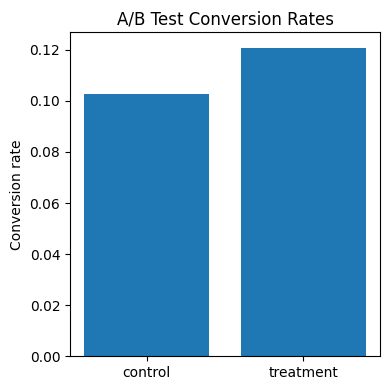

In [1]:
# %% Imports
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

np.random.seed(42)

# %% Simulate experiment data
n_users = 5000
users = pd.DataFrame({"user_id": range(1, n_users + 1)})
users["group"] = np.where(
    np.random.rand(n_users) < 0.5, "control", "treatment"
)

# conversion probabilities
p_control = 0.10
p_treatment = 0.12

users["converted"] = 0
control_mask = users["group"] == "control"
treat_mask = users["group"] == "treatment"

users.loc[control_mask, "converted"] = (
    np.random.rand(control_mask.sum()) < p_control
)
users.loc[treat_mask, "converted"] = (
    np.random.rand(treat_mask.sum()) < p_treatment
)

users.head()

# %% Conversion rates
summary = (
    users.groupby("group")["converted"]
    .agg(["mean", "sum", "count"])
    .reset_index()
    .rename(columns={"mean": "conversion_rate", "sum": "conversions", "count": "n"})
)
print(summary)

# %% Proportion z-test (control vs treatment)
control = summary[summary["group"] == "control"]
treatment = summary[summary["group"] == "treatment"]

conv = np.array([treatment["conversions"].values[0], control["conversions"].values[0]])
nobs = np.array([treatment["n"].values[0], control["n"].values[0]])

from statsmodels.stats.proportion import proportions_ztest

z_stat, p_val = proportions_ztest(count=conv, nobs=nobs, alternative="larger")
lift = (
    treatment["conversion_rate"].values[0] - control["conversion_rate"].values[0]
) / control["conversion_rate"].values[0]

print(f"Z-statistic: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")
print(f"Relative lift in conversion: {lift:.2%}")

alpha = 0.05
if p_val < alpha:
    print("Result: Statistically significant. Recommend launching the treatment.")
else:
    print("Result: Not statistically significant. Do NOT recommend launch yet.")

# %% Plot conversion rates
plt.figure(figsize=(4, 4))
plt.bar(summary["group"], summary["conversion_rate"])
plt.ylabel("Conversion rate")
plt.title("A/B Test Conversion Rates")
plt.tight_layout()
plt.show()
